In [1]:
from pyspark.sql import SparkSession 
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [2]:
# creates a SparkSession object called spark and we specify master to run spark jobs in the cluster yarn.
spark = (SparkSession
      .builder
      .master('yarn')
      .appName("Arxiv_analysis")
      .config("spark.executor.memory", "1g")
      .config("spark.executor.instances", 12)
      .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/26 19:14:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/26 19:14:33 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [10]:
#spark.stop()

In [3]:
# create the schema for our dataset to determine the datatype for each columns)
dbschema = StructType([
    StructField("id", StringType(), True),
    StructField("authors", StringType(), True),
    StructField("title", StringType(), True),
    StructField("abstract", StringType(), True),
    StructField("journal_ref", StringType(), True),
    StructField("category", StringType(), True),
    StructField("update_date", StringType(), True),
])

In [4]:
# import the csv files which was generated by using Hadoop MapReduce
filepath = 'hdfs:///Dat500_Group09/output_meta/part*'
arxiv_df =spark.read.options(delimiter="::", header=False, schema=dbschema).csv(filepath)

In [5]:
# change the column names to the same name for the Arxiv metadata 
arxiv_df = arxiv_df.selectExpr("_c0 as id", "_c1 as authors", "_c2 as title", "_c3 as abstract", 
                                "_c4 as journal_ref", "_c5 as category", "_c6 as update_date")

arxiv_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- journal_ref: string (nullable = true)
 |-- category: string (nullable = true)
 |-- update_date: string (nullable = true)



In [8]:
print("The number of partition for the Data:",arxiv_df.rdd.getNumPartitions())

The number of partition for the Data: 27


In [9]:
print("The Total articles number: ",arxiv_df.count())

The Total articles number:  2203919


### Preprocessing & Analysing the Data
1- Check duplicate values, null values.

2- Recategorizing Arxiv Dataset: labeling the Dataset, Add new columns "main_category" to determine the main category for each article.

3- Extracting the article date from the articles id and save it in a new columns "article_date".

4- Do some transformation for analying the Dataset like the following:

- Displaying the articles number for each main_category.
- Dispalying the articles trends depends on year and main_catefory.
- Displaying the number of authers for each category and get statical values (Avg, max, min) depends on the main_category.

1- Check duplicate values, null values.

In [10]:
# Check null values for all columns in the dataframe by using 'isNull()' method 
print("Check null values for all columns")
for col_Name in arxiv_df.columns:
    print(col_Name, arxiv_df.filter(col(col_Name).isNull()).count())

# Removed duplicate id and return the dataframe after removeing the duplicate, in our data we dont have any duplicate in id
arxiv_df = arxiv_df.dropDuplicates(['id'])

Check null values for all columns


id 0


authors 0


title 0


abstract 0


journal_ref 0


category 0


update_date 0


2- Recategorization the Arxiv data.
- Arxiv data contains a category column which combine one or more ssub category and starting with the main category for the scientic article, regarding to the arxiv website they show maincategory for each sub category, we add a new column which contains the main category for each article.
- The main category for each article was determined by reading the first part of the subcategory, fFor example, if an article is related to math.co category, the main category for this article will be mathematics.
- The main_category column will be used in analysing and classifying the Arxiv data using machine learning models.

In [11]:
arxiv_df = arxiv_df.withColumn("main_category",
                   when(split(arxiv_df.category, "\\.")[0] == "cs", "computer science")
                   .when(split(arxiv_df.category, "\\.")[0] == "math", "mathematics")
                   .when(split(arxiv_df.category, "\\.")[0] == "econ", "economics")
                   .when(split(arxiv_df.category, "\\.")[0] == "eess", "electrical engineering")
                   .when(split(arxiv_df.category, "\\.")[0] == "q-bio", "quantitative biology")
                   .when(split(arxiv_df.category, "\\.")[0] == "q-fin", "quantitative finance")
                   .when(split(arxiv_df.category, "\\.")[0] == "stat", "statistics")                   
                   .otherwise("physics"))


3- Extracting Article Dates from IDs:

In [12]:
from pyspark.sql.functions import to_date, substring, regexp_replace, split, concat, lit

# Extract date for first the format of article IDs (math.GT/YYMM123)  
arxiv_df = arxiv_df.withColumn("date_string",    
        when( arxiv_df["id"].contains("/") & (substring(split(arxiv_df["id"], "/")[1], 1, 2) >= "90"), 
                concat(lit("19"), substring(split(arxiv_df["id"], "/")[1], 1, 2), substring(split(arxiv_df["id"], "/")[1], 3, 2))
            )
        .when( arxiv_df["id"].contains("/") & (substring(split(arxiv_df["id"], "/")[1], 1, 2) < "90"),
                concat(lit("20"), substring(split(arxiv_df["id"], "/")[1], 1, 2), substring(split(arxiv_df["id"], "/")[1], 3, 2))                
                # extract date for the second format of article IDs (YYMM.123)         
            ).otherwise( concat(lit("20"), substring("id", 1, 2), substring("id", 3, 2)))
).withColumn("article_date", to_date("date_string", "yyyyMM"))

# Cleaning, the date contains extra character \t at the end we remove this char
arxiv_df = arxiv_df.withColumn('update_date', regexp_replace(arxiv_df['update_date'], "\t", ""))

clean_arxiv_df = arxiv_df.drop("date_string")

clean_arxiv_df.show(7, False)

+---------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
# check if the new columns has null values 
null_count = clean_arxiv_df.filter(clean_arxiv_df["article_date"].isNull()).count()

# print the count
print("Number of null values in article_date column:", null_count)

Number of null values in article_date column: 0


- Extracting the number of authors:

The number of authors for each article is extracted from the "authors" column in the Arxiv dataset, where the names of all authors are listed and separated by commas. Some articles may use "and" to separate the authors as well.

In [16]:

clean_arxiv_df = clean_arxiv_df.withColumn('splitted_authors', regexp_replace('authors', ' and ', ','))\
                    .withColumn('authers_num', size(split('splitted_authors', ',')))  
clean_arxiv_df = clean_arxiv_df.drop("splitted_authors")

In [17]:
# Show the result
clean_arxiv_df.show(3, False)

+---------+---------------------------------------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
## The data now is clean and ready to do the analyzing part

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [19]:
# Display the count for each main category
category_df = clean_arxiv_df.groupBy("main_category").count()
pd_category_df = category_df.toPandas()
# Sort the categories by count
pd_category_sort = pd_category_df.sort_values(by='count', ascending=False)


In [20]:
pd_category_sort.head(10)

,main_category,count
0,computer science,397171
1,electrical engineering,35336
2,quantitative biology,25065
3,mathematics,446127
4,economics,5103
5,statistics,41542
6,quantitative finance,9850
7,physics,1243725


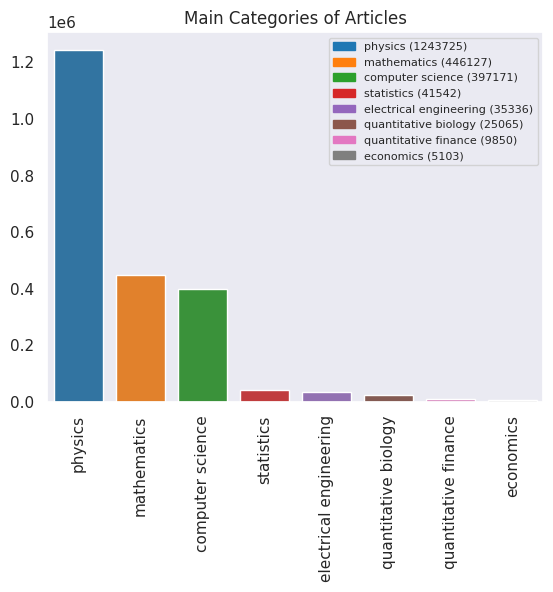

In [21]:
# pastel, Set2, Dark2, Paired,tab10
sns.set(style="dark")

colors = sns.color_palette('tab10', len(pd_category_sort))
ax = sns.barplot(x="main_category", y="count", data=pd_category_sort, palette=colors)

plt.xticks(rotation=90)
# create a custom legend with colored labels
legend_labels = [f"{category} ({count})" for category, count in zip(pd_category_sort['main_category'], pd_category_sort['count'])]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
ax.legend(handles=legend_handles, labels=legend_labels, fontsize=8)
ax.set_title('Main Categories of Articles')
ax.set_xlabel(None)
ax.set_ylabel(None)

plt.show()


In [22]:
# group by year and main_category and count the articles
counts_by_category_year = clean_arxiv_df.groupBy(year("article_date").alias("year"), "main_category").count().orderBy("year", "count", ascending=[1, 0])

main_categorylist = ['computer science', 'physics', 'mathematics','economics','electrical engineering', 'quantitative biology', 'quantitative finance', 'statistics']

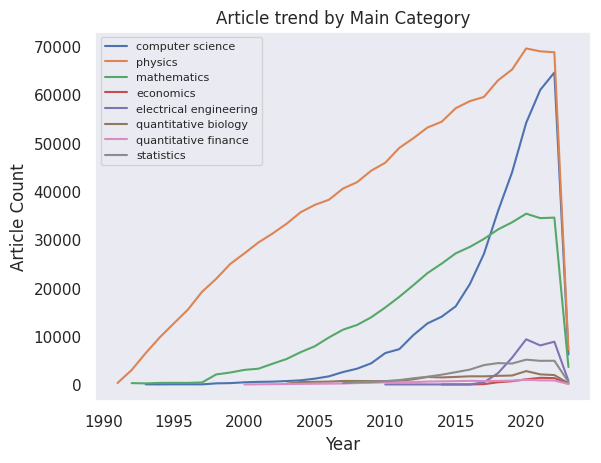

In [24]:
# create a line chart for each main category
for category in main_categorylist:
    # filter the dataframe to get data for the current category
    data = counts_by_category_year.filter(counts_by_category_year["main_category"] == category).toPandas()

    sns.lineplot(data=data, x="year", y="count", label=category)
   

# add chart title and labels
plt.title("Article trend by Main Category")
plt.xlabel("Year")
plt.ylabel("Article Count")
plt.legend(fontsize=8)

plt.show()

In [26]:
#from pyspark.sql.functions import avg, min, max, year
#sc.

# group by main category, aggregate max authors, avg auther no
auther_arxiv_df = clean_arxiv_df.groupBy("main_category", year("article_date").alias("article_year")) \
  .agg(round(avg("authers_num"),0).alias("avg_authors"),
       min("authers_num").alias("min_authors"),
       max("authers_num").alias("max_authors")).orderBy("main_category", "article_year", "avg_authors")


In [27]:
auther_arxiv_df.show(10, False)

+----------------+------------+-----------+-----------+-----------+
|main_category   |article_year|avg_authors|min_authors|max_authors|
+----------------+------------+-----------+-----------+-----------+
|computer science|1993        |1.0        |1          |3          |
|computer science|1994        |2.0        |1          |3          |
|computer science|1995        |2.0        |1          |5          |
|computer science|1996        |2.0        |1          |4          |
|computer science|1997        |2.0        |1          |5          |
|computer science|1998        |3.0        |1          |16         |
|computer science|1999        |3.0        |1          |23         |
|computer science|2000        |2.0        |1          |10         |
|computer science|2001        |2.0        |1          |15         |
|computer science|2002        |2.0        |1          |15         |
+----------------+------------+-----------+-----------+-----------+
only showing top 10 rows



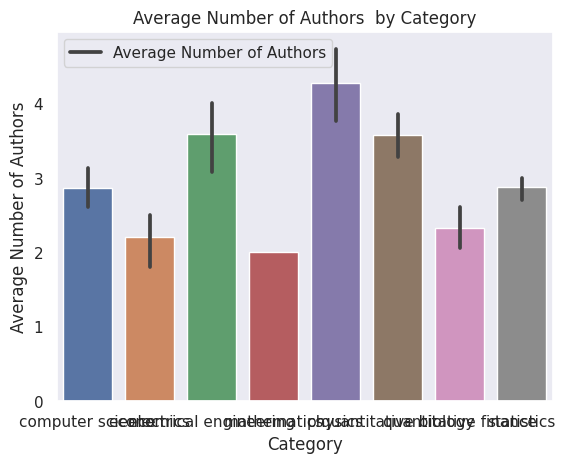

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

df_pandas = auther_arxiv_df.toPandas()

sns.barplot(data=df_pandas, x="main_category", y="avg_authors")

plt.xticks(rotation=90)
plt.title("Average Number of Authors  by Category")
plt.xlabel("Category")
plt.ylabel("Average Number of Authors")

# add legend
plt.legend(labels=["Average Number of Authors"])

plt.show()


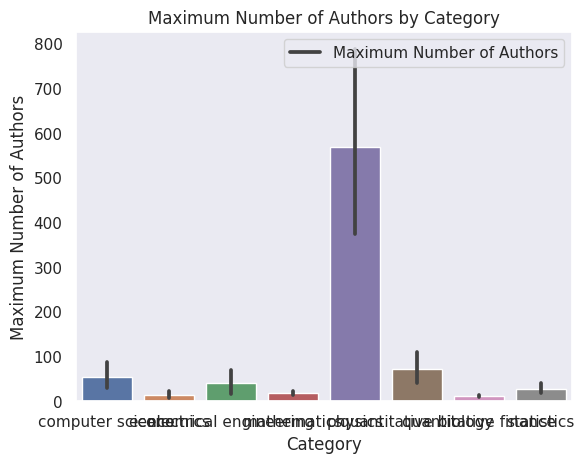

In [33]:
# Shaima_notes : it is better to sort depends on the max num before plot
import seaborn as sns
import matplotlib.pyplot as plt

df_pandas = auther_arxiv_df.toPandas()

sns.barplot(data=df_pandas, x="main_category", y="max_authors")

plt.xticks(rotation=90)
plt.title("Maximum Number of Authors by Category")
plt.xlabel("Category")
plt.ylabel("Maximum Number of Authors")

# add legend
plt.legend(labels=["Maximum Number of Authors"])

plt.show()


In [35]:

# the maximum number of authors in each category
max_authors_by_category = df_pandas.groupby('main_category')['max_authors'].max()

print("Maximum number of authors for each category:")
print(max_authors_by_category)


Maximum number of authors for each category:
main_category
computer science           427
economics                   40
electrical engineering     170
mathematics                 60
physics                   2611
quantitative biology       347
quantitative finance        20
statistics                 122
Name: max_authors, dtype: int32


In [35]:
# Assuming that the DataFrame is called 'df' and the column is called 'author'
auther_arxiv_df.show(7, False)

+----------------+------------+-----------+-----------+-----------+
|main_category   |article_year|avg_authors|min_authors|max_authors|
+----------------+------------+-----------+-----------+-----------+
|computer science|1993        |1.0        |1          |3          |
|computer science|1994        |2.0        |1          |3          |
|computer science|1995        |2.0        |1          |5          |
|computer science|1996        |2.0        |1          |4          |
|computer science|1997        |2.0        |1          |5          |
|computer science|1998        |3.0        |1          |16         |
|computer science|1999        |3.0        |1          |23         |
+----------------+------------+-----------+-----------+-----------+
only showing top 7 rows

